In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pickle
import random
random.seed(42)
np.random.seed(42)

In [3]:
with open("../ressources/llm_evaluated_concat_s14-18_24-12-24.pickle", "rb") as file:
#with open("../ressources/llm_evaluated_concat_s14n600_s15n600_train_2024-12-12_16.pickle", "rb") as file:
#with open("../ressources/llm_evaluated_s14_n300_24-12-17.pickle", "rb") as file:
#with open("testdata.pkl", "rb") as file:
    original_df = pickle.load(file)

In [4]:
original_df["original_index"] = original_df.index

In [5]:

original_df["type"] = original_df["parameters"].map(lambda x: str(type(x.objective_params).__name__))

original_df["score_diff"] = original_df["llm_avg_score"] - original_df["avg_score"]
original_df['llm_better'] = original_df['score_diff'] > 0

original_df['llm_correct'] = original_df['score_diff'] > -original_df.groupby('type')['avg_score'].transform(lambda x: x.abs().mean()/10.0)
#original_df['llm_correct'] = original_df['score_diff'] > -original_df['avg_score'].map(lambda x: abs(x)/10.0)

def minmax(x):
    return (x - x.min()) / (x.max() - x.min())

original_df['rel_avg_score'] = original_df.groupby('type')['avg_score'].transform(minmax)
original_df['rel_llm_avg_score'] = original_df.groupby('type')['llm_avg_score'].transform(minmax)

In [6]:
# Step 1: Remove NaN and None values
df_cleaned = original_df.dropna()

# Step 2: Remove Inf values
df_cleaned = df_cleaned[~df_cleaned.isin([np.inf, -np.inf]).any(axis=1)]

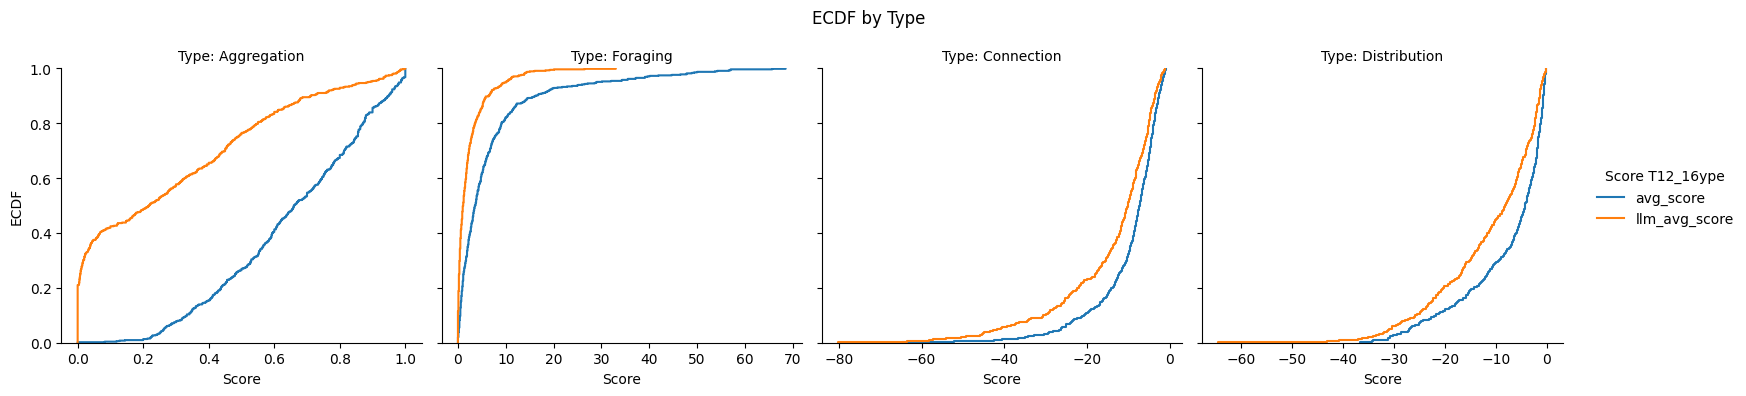

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Melt the DataFrame to long format for seaborn
df_melted = df_cleaned.melt(id_vars=['type'], value_vars=['avg_score', 'llm_avg_score'], 
                             var_name='Score Type', value_name='Score')

# Create a FacetGrid with ECDF plots
g = sns.FacetGrid(df_melted, col='type', hue='Score Type', height=4, aspect=1, sharex=False)
g.map_dataframe(sns.ecdfplot, x='Score', stat='proportion')
g.set_titles(col_template='Type: {col_name}')
g.set_axis_labels('Score', 'ECDF')
# Add a legend
g.add_legend(title='Score T12_16ype')

# Show the plot
g.figure.suptitle('ECDF by Type')
g.tight_layout()
plt.show()


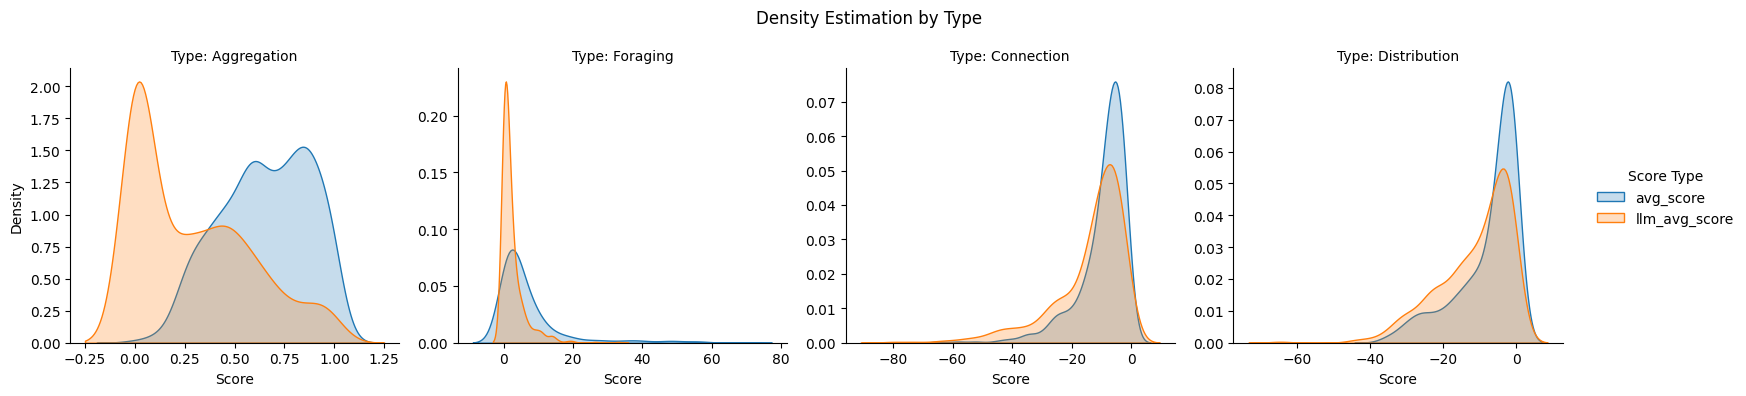

In [8]:
df_melted = df_cleaned.melt(id_vars=['type'], value_vars=['avg_score', 'llm_avg_score'], 
                             var_name='Score Type', value_name='Score')

# Create a FacetGrid with density plots
g = sns.FacetGrid(df_melted, col='type', hue='Score Type', height=4, aspect=1, sharex=False, sharey=False)
g.map_dataframe(sns.kdeplot, x='Score', fill=True)  # Use kdeplot for density
g.set_titles(col_template='Type: {col_name}')
g.set_axis_labels('Score', 'Density')


# Add a legend
g.add_legend(title='Score Type')

# Show the plot
g.figure.suptitle('Density Estimation by Type')
g.tight_layout()
plt.show()

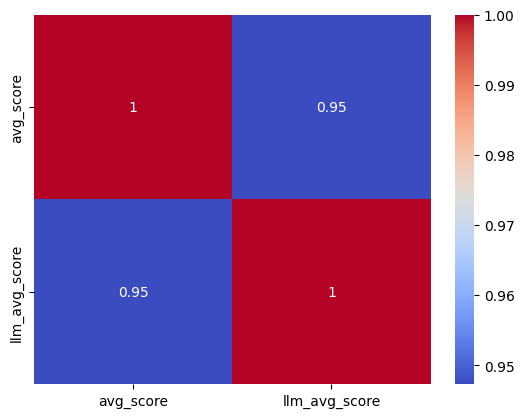

In [9]:
corrmat = df_cleaned[["avg_score","llm_avg_score"]].corr(method="spearman")

sns.heatmap(corrmat, annot=True, cmap='coolwarm')
plt.show()

/tmp/ipykernel_1515088/3496947997.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_by_type = df.groupby('type').apply(lambda x: x[[x_key, y_key]].corr().iloc[0, 1])


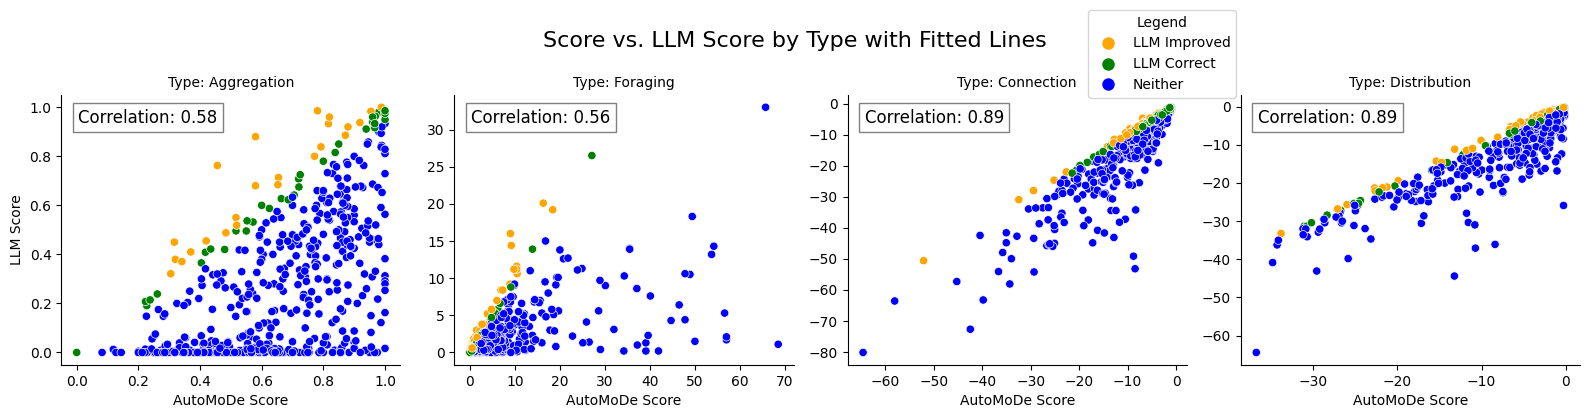

In [10]:
df = df_cleaned
type_order = list(df["type"].unique())
g = sns.FacetGrid(df, col='type', height=4, aspect=1, sharex=False, col_order=type_order, sharey=False)
x_key = "avg_score"
y_key="llm_avg_score"

# Create a new column for color based on llm_better and llm_correct
def color_condition(row):
    if row['llm_better']:
        return 'orange'  # Color for llm_better being True
    elif row['llm_correct']:
        return 'green'  # Color for llm_correct being True
    else:
        return 'blue'  # Default color

df['color'] = df.apply(color_condition, axis=1)

# Map the regression plot to the FacetGrid
g.map_dataframe(sns.scatterplot, x=x_key, y=y_key, hue='color', palette={'green': 'green', 'orange': 'orange', 'blue': 'blue'})
#g.map_dataframe(sns.regplot, x=x_key, y=y_key, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, scatter=False)

# Calculate correlation by type
correlation_by_type = df.groupby('type').apply(lambda x: x[[x_key, y_key]].corr().iloc[0, 1])

# Add correlation text to each facet in the correct order
for ax, type_name in zip(g.axes.flat, type_order):
    corr_value = correlation_by_type[type_name]
    ax.text(0.05, 0.95, f'Correlation: {corr_value:.2f}', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Add titles and labels
g.set_titles(col_template='Type: {col_name}')
g.set_axis_labels('AutoMoDe Score', 'LLM Score')
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='LLM Improved', markerfacecolor='orange', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='LLM Correct', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Neither', markerfacecolor='blue', markersize=10)
]

g.fig.legend(handles=handles, loc='upper right',bbox_to_anchor=(0.78, 1.05), title='Legend')
# Show the plot
g.figure.suptitle('Score vs. LLM Score by Type with Fitted Lines', fontsize=16)
g.tight_layout()
g.fig.subplots_adjust(top=0.82)  # Adjust the title to fit
plt.show()

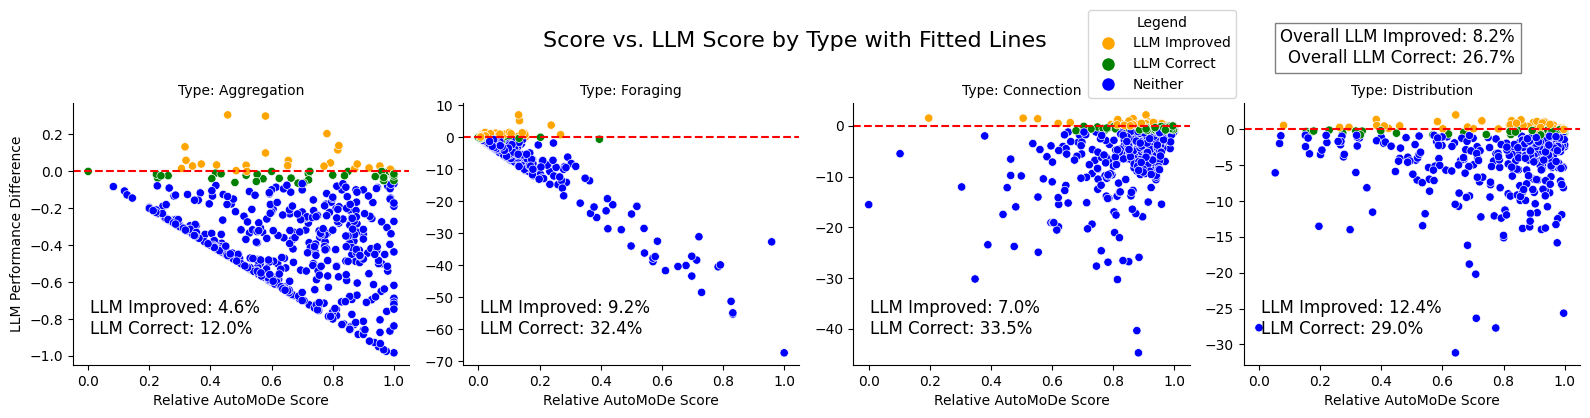

In [11]:
# Calculate the mean ratios for llm_better and llm_correct
ratios = df.groupby('type').agg(
    llm_better_mean=('llm_better', 'mean'),
    llm_correct_mean=('llm_correct', 'mean')
).reset_index()

# Convert to percentage
ratios['llm_better_ratio'] = ratios['llm_better_mean'] * 100
ratios['llm_correct_ratio'] = ratios['llm_correct_mean'] * 100

# Create the FacetGrid
type_order = list(df["type"].unique())
g = sns.FacetGrid(df, col='type', height=4, aspect=1, sharex=False, col_order=type_order, sharey=False)

# Create a new column for color based on llm_better and llm_correct
def color_condition(row):
    if row['llm_better']:
        return 'orange'  # Color for llm_better being True
    elif row['llm_correct']:
        return 'green'  # Color for llm_correct being True
    else:
        return 'blue'  # Default color

df['color'] = df.apply(color_condition, axis=1)

# Calculate total (unaggregated) ratios
total_llm_better_ratio = df['llm_better'].mean() * 100
total_llm_correct_ratio = df['llm_correct'].mean() * 100

# Map the scatter plot to the FacetGrid with color based on the new column
g.map_dataframe(sns.scatterplot, x='rel_avg_score', y='score_diff', hue='color', palette={'green': 'green', 'orange': 'orange', 'blue': 'blue'})

# Add horizontal line at y=0
for ax in g.axes.flat:
    ax.axhline(0, color='red', linestyle='--')  # Customize the color and linestyle

# Add titles and labels
g.set_titles(col_template='Type: {col_name}')
g.set_axis_labels('Relative AutoMoDe Score', 'LLM Performance Difference')

# Add the ratio text to each facet
for ax, type_name in zip(g.axes.flat, type_order):
    llm_better_value = ratios.loc[ratios['type'] == type_name, 'llm_better_ratio'].values[0]
    llm_correct_value = ratios.loc[ratios['type'] == type_name, 'llm_correct_ratio'].values[0]
    ax.text(0.05, 0.25, f'LLM Improved: {llm_better_value:.1f}%\nLLM Correct: {llm_correct_value:.1f}%', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top')

g.fig.text(0.95, 0.9, f'Overall LLM Improved: {total_llm_better_ratio:.1f}%\nOverall LLM Correct: {total_llm_correct_ratio:.1f}%', 
           ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
# Create a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='LLM Improved', markerfacecolor='orange', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='LLM Correct', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Neither', markerfacecolor='blue', markersize=10)
]

g.fig.legend(handles=handles, loc='upper right',bbox_to_anchor=(0.78, 1.05), title='Legend')
# Show the plot
g.figure.suptitle('Score vs. LLM Score by Type with Fitted Lines', fontsize=16)
g.tight_layout()
g.fig.subplots_adjust(top=0.8)  # Adjust the title to fit
plt.show()

In [12]:
df.shape

(2022, 19)

In [13]:
i= 0
r = df[(df["score_diff"] > -0.2 )& (df["type"] == "Aggregation")].iloc[i][["type","avg_score", "llm_avg_score","score_diff", "llm_better", "llm_correct", "index", "original_index"]]

r




type              Aggregation
avg_score                 1.0
llm_avg_score        0.933333
score_diff          -0.066667
llm_better              False
llm_correct             False
index                      41
original_index             41
Name: 41, dtype: object

In [14]:
original_df.iloc[r.original_index]

index                                                               41
description          With a length of 2.17 meters, width of 6.48 me...
configuration        <?xml version="1.00" ?>\n<config>\n  <swarm-el...
parameters           MissionParams(arena_params=RectangularArena(le...
argos                <?xml version="1.00" ?>\n<argos-configuration>...
behavior_tree        --nroot 3 --nchildroot 3 --n0 0 --nchild0 2 --...
scores               [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
avg_score                                                          1.0
llm_scores           [1.0, 0.933333, 0.866667, 0.933333, 1.0, 1.0, ...
llm_behavior_tree     --nroot 3 --nchildroot 3 --n0 0 --nchild0 2 -...
llm_avg_score                                                 0.933333
original_index                                                      41
type                                                       Aggregation
score_diff                                                   -0.066667
llm_be

In [15]:
df.groupby('type').agg(
    llm_better_mean=('llm_better', 'mean'),
    llm_correct_mean=('llm_correct', 'mean')
).reset_index()

,type,llm_better_mean,llm_correct_mean
0,Aggregation,0.045889,0.120459
1,Connection,0.069721,0.334661
2,Distribution,0.124169,0.290466
3,Foraging,0.091575,0.324176


In [17]:
df.groupby('type').agg(
    llm_avg_score=('llm_avg_score', 'mean'),
    automode_avg_score=('avg_score', 'mean')
).reset_index()

,type,llm_avg_score,automode_avg_score
0,Aggregation,0.174552,0.672241
1,Connection,-17.988277,-8.433796
2,Distribution,-19.142099,-7.612111
3,Foraging,2.086538,8.853846
